# Set Path

In [96]:
model_path = '/kaggle/input/outputmodel/Model'
new_model_path = '/kaggle/input/outputmodel/MyModel'
video_deepfake_path = '/kaggle/input/video-deepfake/2020312582'
deepfake_path = '/kaggle/input/deepfake'
prediction_path = '/kaggle/working/'
output_model_path = '/kaggle/working/Model'

# Import Libraries

In [45]:
!pip install timm

In [46]:
import pandas as pd
import os
from os import PathLike
from pathlib import Path
from PIL import Image
import torchvision.transforms as tf
from torch.utils.data import Dataset, DataLoader
from typing import Tuple
from tqdm.autonotebook import tqdm

import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import timm

from sklearn.metrics import accuracy_score, f1_score, precision_score, recall_score
import numpy as np

import matplotlib.pyplot as plt

In [98]:
Path(output_model_path).mkdir(parents=True, exist_ok=True)

In [47]:
your_prediction = pd.read_csv(Path(video_deepfake_path) / 'your_prediction.csv')
your_prediction

,video,face,label,predict
0,video_0,face_0.png,1,NaN
1,video_0,face_1.png,1,NaN
2,video_0,face_2.png,0,NaN
3,video_0,face_3.png,1,NaN
4,video_1,face_0.png,0,NaN
...,...,...,...,...
70,video_18,face_0.png,0,NaN
71,video_19,face_0.png,0,NaN
72,video_19,face_1.png,1,NaN
73,video_19,face_2.png,0,NaN


# Create DataLoader

In [48]:
class VideoDeepFakeDataset(Dataset):
    def __init__(self, root: PathLike, pred: pd.DataFrame, transform=None) -> None:
        self.root = Path(root)
        self.pred = pred
        self.transform = transform
        self.items = self.load()

    def load(self):
        items = []
        videos = self.pred['video']
        faces = self.pred['face']
        labels = self.pred['label']
        for i in range(len(self.pred)):
          video = videos[i]
          face = faces[i]
          label = labels[i]
          file = self.root / video / face
          print(file, label)
          items.append((file, label))
        return items

    def __len__(self):
        return len(self.items)

    def __getitem__(self, idx):
        file, label = self.items[idx]
        image = Image.open(file).convert('RGB')
        if self.transform:
           image = self.transform(image)
        return image, label

In [49]:
def CreateVideoDeepFakeDataLoader(root: PathLike, pred: pd.DataFrame) -> DataLoader:
    # Transform Image Data
    transform = tf.Compose([
        tf.Resize((224, 224)),
        tf.ToTensor(),
        tf.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
    ])

    # Create VideoDeepFakeDataset
    ds = VideoDeepFakeDataset(root=root, pred=pred, transform=transform)

    # Create DataLoader
    batch_size = 32  # Min-batches
    dl = DataLoader(ds, batch_size=batch_size, shuffle=True)

    return dl

In [50]:
dl = CreateVideoDeepFakeDataLoader(video_deepfake_path, your_prediction)

/kaggle/input/video-deepfake/2020312582/video_0/face_0.png 1
/kaggle/input/video-deepfake/2020312582/video_0/face_1.png 1
/kaggle/input/video-deepfake/2020312582/video_0/face_2.png 0
/kaggle/input/video-deepfake/2020312582/video_0/face_3.png 1
/kaggle/input/video-deepfake/2020312582/video_1/face_0.png 0
/kaggle/input/video-deepfake/2020312582/video_1/face_1.png 1
/kaggle/input/video-deepfake/2020312582/video_1/face_2.png 0
/kaggle/input/video-deepfake/2020312582/video_1/face_3.png 0
/kaggle/input/video-deepfake/2020312582/video_2/face_0.png 0
/kaggle/input/video-deepfake/2020312582/video_2/face_1.png 0
/kaggle/input/video-deepfake/2020312582/video_2/face_2.png 1
/kaggle/input/video-deepfake/2020312582/video_2/face_3.png 1
/kaggle/input/video-deepfake/2020312582/video_3/face_0.png 0
/kaggle/input/video-deepfake/2020312582/video_3/face_1.png 1
/kaggle/input/video-deepfake/2020312582/video_3/face_2.png 0
/kaggle/input/video-deepfake/2020312582/video_3/face_3.png 0
/kaggle/input/video-deep

# Load Models

In [51]:
device = 'cuda:0'

model1 = timm.create_model('efficientnet_b0',num_classes=2, pretrained=True).to(device)
model2 = timm.create_model('xception',num_classes=2, pretrained=True).to(device)
model3 = timm.create_model('mobilenetv2_100', num_classes=2, pretrained=True).to(device)
x     = torch.randn(32, 3, 224, 224).to(device)
model1(x).shape

/opt/conda/lib/python3.10/site-packages/timm/models/_factory.py:114: UserWarning: Mapping deprecated model name xception to current legacy_xception.
  model = create_fn(


torch.Size([32, 2])

In [52]:
criterion = nn.CrossEntropyLoss()
optimizer1 = optim.Adam(model1.parameters(), lr=0.001)
optimizer2 = optim.Adam(model2.parameters(), lr=0.001)
optimizer3 = optim.Adam(model3.parameters(), lr=0.001)

In [53]:
model_optimizers = {
    'Efficient_b0': [model1, optimizer1],
    'Xception': [model2, optimizer2],
    'MobileNetV2': [model3, optimizer3],
}

In [54]:
files = list(Path(model_path).iterdir())
files

[PosixPath('/kaggle/input/outputmodel/Model/Xception_LowNT.pth'),
 PosixPath('/kaggle/input/outputmodel/Model/MobileNetV2_HighF2F.pth'),
 PosixPath('/kaggle/input/outputmodel/Model/Efficient_b0_LowNT.pth'),
 PosixPath('/kaggle/input/outputmodel/Model/Efficient_b0_HighNT.pth'),
 PosixPath('/kaggle/input/outputmodel/Model/Xception_HighNT.pth'),
 PosixPath('/kaggle/input/outputmodel/Model/Xception_LowF2F.pth'),
 PosixPath('/kaggle/input/outputmodel/Model/MobileNetV2_LowF2F.pth'),
 PosixPath('/kaggle/input/outputmodel/Model/Efficient_b0_HighF2F.pth'),
 PosixPath('/kaggle/input/outputmodel/Model/Xception_HighF2F.pth'),
 PosixPath('/kaggle/input/outputmodel/Model/MobileNetV2_HighNT.pth'),
 PosixPath('/kaggle/input/outputmodel/Model/MobileNetV2_LowNT.pth'),
 PosixPath('/kaggle/input/outputmodel/Model/Efficient_b0_LowF2F.pth')]

In [55]:
model_dict = {}

for file_path in files:
    model_name = '_'.join(file_path.stem.split('_')[:-1])
    model, optimizer =  model_optimizers[model_name]
    checkpoint = torch.load(file_path)
    model.load_state_dict(checkpoint['model_state_dict'])

    model_dict[file_path] = [model, model_name]

# Test Models (Prediction by HQ, LQ Models)

In [56]:
def test(test_dl, model):
    model.eval()

    predictions = list()
    targets = list()

    with torch.no_grad():
        for images, labels in test_dl:
            images = images.to(device)
            labels = labels.to(device)

            outputs = model(images)
            _, predicted = torch.max(outputs.data, 1)

            predictions += predicted.tolist()
            targets += labels.tolist()

    return predictions, targets

In [57]:
test_results = []
for file_path, model_info in model_dict.items():
  model, name = model_info
  category = file_path.stem.split('_')[-1]
  predictions, targets = test(dl, model)
  result = (name, category, predictions, targets)
  test_results.append(result)

In [58]:
category_acc = {'H': [0 for _ in range(len(test_results[0][2]))], 'L': [0 for _ in range(len(test_results[0][2]))]}

for result in test_results:
  name, category, predictions, targets = result
  for i in range(len(predictions)):
    acc = 1 if targets[i] == predictions[i] else 0
    category_acc[category[0]][i] += acc

In [59]:
HQ_acc = np.array(category_acc['H']) / (len(test_results) // 2)
LQ_acc = np.array(category_acc['L']) / (len(test_results) // 2)

your_prediction['predict(HQ model)'] = HQ_acc.round(2)
your_prediction['predict(LQ model)'] = LQ_acc.round(2)
your_prediction

,video,face,label,predict,predict(HQ model),predict(LQ model)
0,video_0,face_0.png,1,NaN,0.33,0.50
1,video_0,face_1.png,1,NaN,0.50,0.50
2,video_0,face_2.png,0,NaN,0.50,0.50
3,video_0,face_3.png,1,NaN,0.83,0.50
4,video_1,face_0.png,0,NaN,0.17,0.50
...,...,...,...,...,...,...
70,video_18,face_0.png,0,NaN,0.33,0.67
71,video_19,face_0.png,0,NaN,0.50,0.67
72,video_19,face_1.png,1,NaN,0.33,0.67
73,video_19,face_2.png,0,NaN,0.33,0.50


In [60]:
round(sum(HQ_acc)/len(HQ_acc), 2), round(sum(LQ_acc)/len(LQ_acc), 2)

(0.51, 0.51)

In [61]:
your_prediction.to_csv(Path(prediction_path) / 'your_prediction.csv', index=False)

# Ensemble Efficient_b0 and Xception

In [62]:
models = [model_info[0] for model_info in model_dict.values()]
for model in models:
  for param in model.parameters():    
    param.requires_grad = False

In [63]:
class EnsembleModel(nn.Module):
    def __init__(self, num_classes, xception_models, efficient_models):
        super(EnsembleModel, self).__init__()
        self.xception_models = nn.ModuleList(xception_models)
        self.efficientnet_models = nn.ModuleList(efficient_models)
        self.fc = nn.Linear(8 * num_classes, num_classes)

    def forward(self, x):
        xception_outputs = []
        efficientnet_outputs = []
        for xception_model in self.xception_models:
            xception_outputs.append(xception_model(x))
        for efficientnet_model in self.efficientnet_models:
            efficientnet_outputs.append(efficientnet_model(x))
        xception_outputs = torch.cat(xception_outputs, dim=1)
        efficientnet_outputs = torch.cat(efficientnet_outputs, dim=1)
        outputs = torch.cat([xception_outputs, efficientnet_outputs], dim=1)
        outputs = self.fc(outputs)
        return outputs

In [64]:
xception_models = [model_info[0] for model_info in model_dict.values() if model_info[1][0] == 'X']
efficient_models = [model_info[0] for model_info in model_dict.values() if model_info[1][0] == 'E']

num_classes = 2
ensemble_model = EnsembleModel(num_classes, xception_models, efficient_models)
ensemble_model.to(device)
x = torch.randn(32, 3, 224, 224).to(device)
ensemble_model(x).shape

torch.Size([32, 2])

## Test Ensemble Model

In [65]:
predictions, targets = test(dl, ensemble_model)
result = (name, category, predictions, targets)

In [66]:
ensemble_acc = []
name, category, predictions, targets = result
for i in range(len(predictions)):
  acc = 1 if targets[i] == predictions[i] else 0
  ensemble_acc.append(acc)

total_ensemble_acc = round(sum(ensemble_acc) / len(ensemble_acc), 2)
total_ensemble_acc

0.53

In [67]:
your_prediction['predict(Ensemble model)'] = ensemble_acc
your_prediction

,video,face,label,predict,predict(HQ model),predict(LQ model),predict(Ensemble model)
0,video_0,face_0.png,1,NaN,0.33,0.50,0
1,video_0,face_1.png,1,NaN,0.50,0.50,1
2,video_0,face_2.png,0,NaN,0.50,0.50,0
3,video_0,face_3.png,1,NaN,0.83,0.50,0
4,video_1,face_0.png,0,NaN,0.17,0.50,1
...,...,...,...,...,...,...,...
70,video_18,face_0.png,0,NaN,0.33,0.67,1
71,video_19,face_0.png,0,NaN,0.50,0.67,0
72,video_19,face_1.png,1,NaN,0.33,0.67,1
73,video_19,face_2.png,0,NaN,0.33,0.50,0


In [68]:
your_prediction.to_csv(Path(prediction_path) / 'your_prediction.csv', index=False)

# New Models

In [69]:
# common CNN
class MyModel(nn.Module):
    def __init__(self, num_classes):
        super(MyModel, self).__init__()
        
        # Convolutional layers
        self.conv1 = nn.Conv2d(3, 64, kernel_size=3, stride=1, padding=1)
        self.conv2 = nn.Conv2d(64, 128, kernel_size=3, stride=1, padding=1)
        self.conv3 = nn.Conv2d(128, 256, kernel_size=3, stride=1, padding=1)
        
        # Max pooling layer
        self.maxpool = nn.MaxPool2d(kernel_size=2, stride=2)
        
        # Fully connected layers
        self.fc1 = nn.Linear(256 * 28 * 28, 512)
        self.fc2 = nn.Linear(512, num_classes)
        
        # Activation function
        self.relu = nn.ReLU()
        
    def forward(self, x):
        # Convolutional layers
        x = self.relu(self.conv1(x))
        x = self.maxpool(x)
        x = self.relu(self.conv2(x))
        x = self.maxpool(x)
        x = self.relu(self.conv3(x))
        x = self.maxpool(x)
        
        # Flatten the tensor
        x = x.view(x.size(0), -1)
        
        # Fully connected layers
        x = self.relu(self.fc1(x))
        x = self.fc2(x)
        
        return x

In [72]:
import torchvision.models as models

class ResnetModel(nn.Module):
    def __init__(self, num_classes):
        super(ResnetModel, self).__init__()
        
        self.feature_extractor = models.resnet50(pretrained=True)
        self.feature_extractor.fc = nn.Identity()
        
        self.classifier = nn.Sequential(
            nn.Linear(2048, 512),
            nn.ReLU(),
            nn.Dropout(0.5),
            nn.Linear(512, num_classes)
        )

    def forward(self, x):
        features = self.feature_extractor(x)
        output = self.classifier(features)
        return output

In [73]:
my_model = MyModel(2)
my_model.to(device)
resnet_model = ResnetModel(2)
resnet_model.to(device)
x = torch.randn(32, 3, 224, 224).to(device)

/opt/conda/lib/python3.10/site-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/opt/conda/lib/python3.10/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet50_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet50_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
Downloading: "https://download.pytorch.org/models/resnet50-0676ba61.pth" to /root/.cache/torch/hub/checkpoints/resnet50-0676ba61.pth
100%|██████████| 97.8M/97.8M [00:01<00:00, 99.2MB/s]


In [74]:
# Define Loss Function and Optimizer
criterion = nn.CrossEntropyLoss()
optimizer4 = optim.Adam(my_model.parameters(), lr=0.001)
optimizer5 = optim.Adam(resnet_model.parameters(), lr=0.001)

## Train New Models

In [75]:
class ImageDataset(Dataset):
    def __init__(self, root: str, transform=None):
        self.root = root
        self.transform = transform
        self.files = self.load()

    def load(self):
        files = list()
        for file in os.listdir(self.root):
            if file.startswith('fake_'):
                label = 0
            elif file.startswith('real_'):
                label = 1
            else:
                continue
            files.append((os.path.join(self.root, file), label))
        return files

    def __len__(self):
        return len(self.files)

    def __getitem__(self, idx):
        file, label = self.files[idx]
        image = Image.open(file).convert('RGB')
        if self.transform:
           image = self.transform(image)
        return image, label

In [80]:
def CreateDataLoader(root: str) -> Tuple[DataLoader, DataLoader, DataLoader]:
    # Path of Image Data
    train = os.path.join(root, 'train')
    valid = os.path.join(root, 'val')
    test = os.path.join(root, 'test')

    # Transform Image Data
    transform = tf.Compose([
        tf.Resize((224, 224)),
        tf.ToTensor(),
        tf.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
    ])

    # Create ImageDataset
    train_ds = ImageDataset(root=train, transform=transform)
    valid_ds = ImageDataset(root=valid, transform=transform)
    test_ds = ImageDataset(root=test, transform=transform)

    # Create DataLoader
    batch_size = 32  # Min-batches
    train_dl = DataLoader(train_ds, batch_size=batch_size, shuffle=True)
    valid_dl = DataLoader(valid_ds, batch_size=batch_size, shuffle=True)
    test_dl = DataLoader(test_ds, batch_size=batch_size, shuffle=True)

    return train_dl, valid_dl, test_dl

In [81]:
# Directories
highf2f_dir =  Path(deepfake_path) / 'HQ' / 'f2f_data'
highnt_dir = Path(deepfake_path) / 'HQ'/ 'nt_data'
lowf2f_dir = Path(deepfake_path) / 'LQ' / 'f2f_data'
lownt_dir = Path(deepfake_path) / 'LQ'/ 'nt_data'

highf2f_dl = list(CreateDataLoader(highf2f_dir))
highnt_dl = list(CreateDataLoader(highnt_dir))
lowf2f_dl = list(CreateDataLoader(lowf2f_dir))
lownt_dl = list(CreateDataLoader(lownt_dir))

In [105]:
def train(train_dl, valid_dl, model, optimizer, num_epochs=100, save=False, save_path=None):
    train_losses = list()
    train_accs = list()
    valid_losses = list()
    valid_accs = list()
    
    best_valid_loss = float('inf')  # Set the initial minimum validation loss value
    best_state_dict = None
    
    for epoch in range(num_epochs):
        total_loss = 0.0
        correct = 0
        total = 0

        model.train()
        for images, labels in train_dl:
            images = images.to(device)
            labels = labels.to(device)

            optimizer.zero_grad()

            # Forward pass and loss calculation
            outputs = model(images)
            loss = criterion(outputs, labels)

            # Backward pass and weight update
            loss.backward()
            optimizer.step()

            total_loss += loss.item()
            _, predicted = outputs.max(1)
            total += labels.size(0)
            correct += predicted.eq(labels).sum().item()

        # Record training loss and accuracy for each epoch
        train_loss = total_loss / len(train_dl)
        train_acc = 100.0 * correct / total
        train_losses.append(train_loss)
        train_accs.append(train_acc)

        # Validation
        model.eval()
        total_loss = 0.0
        correct = 0
        total = 0

        with torch.no_grad():
            for images, labels in valid_dl:
                images = images.to(device)
                labels = labels.to(device)

                outputs = model(images)
                loss = criterion(outputs, labels)

                total_loss += loss.item()
                _, predicted = outputs.max(1)
                total += labels.size(0)
                correct += predicted.eq(labels).sum().item()

        # Record training loss and accuracy for each epoch
        valid_loss = total_loss / len(valid_dl)
        valid_acc = 100.0 * correct / total
        valid_losses.append(valid_loss)
        valid_accs.append(valid_acc)

        # Print Result for each epoch
        print(f'Epoch [{epoch+1}/{num_epochs}], '
              f'Train Loss: {train_loss:.4f}, Train Acc: {train_acc:.2f}%, '
              f'Valid Loss: {valid_loss:.4f}, Valid Acc: {valid_acc:.2f}%')
        
        # Check if current model has the best validation loss
        if valid_loss < best_valid_loss:
            best_valid_loss = valid_loss
            best_state_dict = model.state_dict()

        if save and best_state_dict is not None:
            checkpoint = {
                'model_state_dict': best_state_dict,
                'metrics': {
                    'train_losses': train_losses,
                    'train_accs': train_accs,
                    'valid_losses': valid_losses,
                    'valid_accs': valid_accs
                },
                'epoch': epoch
            }
            torch.save(checkpoint, save_path)
    return best_state_dict, train_losses, train_accs, valid_losses, valid_accs

In [83]:
model_optimizers = {
    'My': [my_model, optimizer4],
    'Resnet': [resnet_model, optimizer5],
}

dataloaders = {
    'HighF2F': highf2f_dl,
    'HighNT': highnt_dl,
    'LowF2F': lowf2f_dl,
    'LowNT': lownt_dl,
}

In [85]:
train_results = list()
test_results = list()

for name, model_optimizer in model_optimizers.items():
    for category, dataloader in dataloaders.items():
        model, optimizer = model_optimizer
        train_dl, valid_dl, test_dl = dataloader
        save_path = os.path.join(new_model_path, f'{name}_{category}.pth')
        if Path(save_path).exists():
            checkpoint = torch.load(save_path)
            model.load_state_dict(checkpoint['model_state_dict'])
            train_losses = checkpoint['metrics']['train_losses']
            train_accs = checkpoint['metrics']['train_accs']
            valid_losses = checkpoint['metrics']['valid_losses']
            valid_accs = checkpoint['metrics']['valid_accs']
        else:
            save_path = os.path.join(output_model_path, f'{name}_{category}.pth')
            print(f'\n-----Train {name} model for {category} Dataset-----')
            best_state_dict, train_losses, train_accs, valid_losses, valid_accs = train(train_dl, valid_dl, model, optimizer, num_epochs=100, save=True, save_path=save_path)
            model.load_state_dict(best_state_dict)
            predictions, targets = test(test_dl, model)
        train_results.append([name, category, train_losses, train_accs, valid_losses, valid_accs])
        test_results.append([name, category, predictions, targets])

In [86]:
def plot(train_losses, train_accs, valid_losses, valid_accs, name, category):
    plt.figure(figsize=(12, 4))
    plt.subplot(1, 2, 1)
    plt.plot(train_losses, label='Train')
    plt.plot(valid_losses, label='Validation')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.title(f'{name}: {category} Training and Validation Loss')
    plt.legend()

    plt.subplot(1, 2, 2)
    plt.plot(train_accs, label='Train')
    plt.plot(valid_accs, label='Validation')
    plt.xlabel('Epoch')
    plt.ylabel('Accuracy (%)')
    plt.title(f'{name}: {category} Training and Validation Accuracy')
    plt.legend()

    plt.tight_layout()
    plt.show()

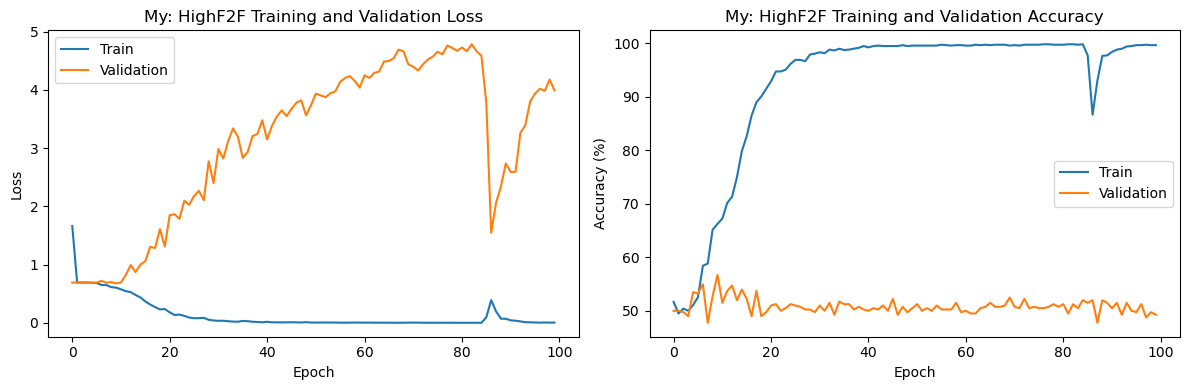

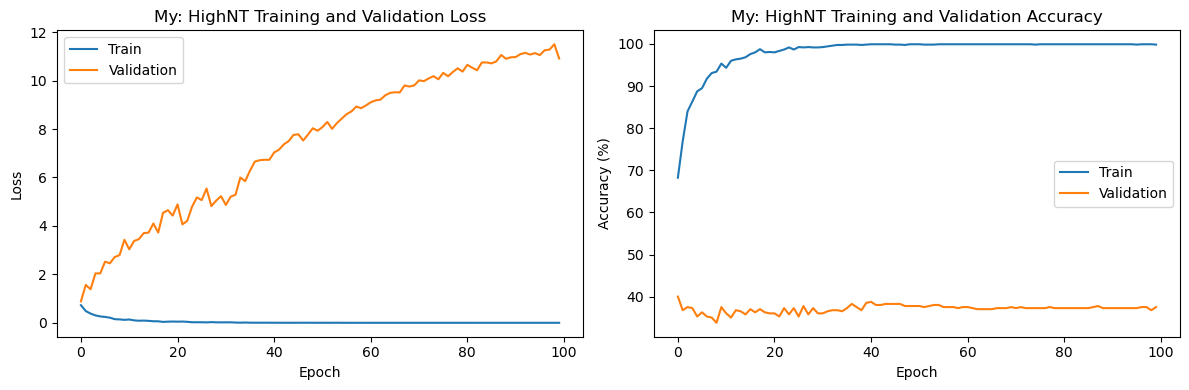

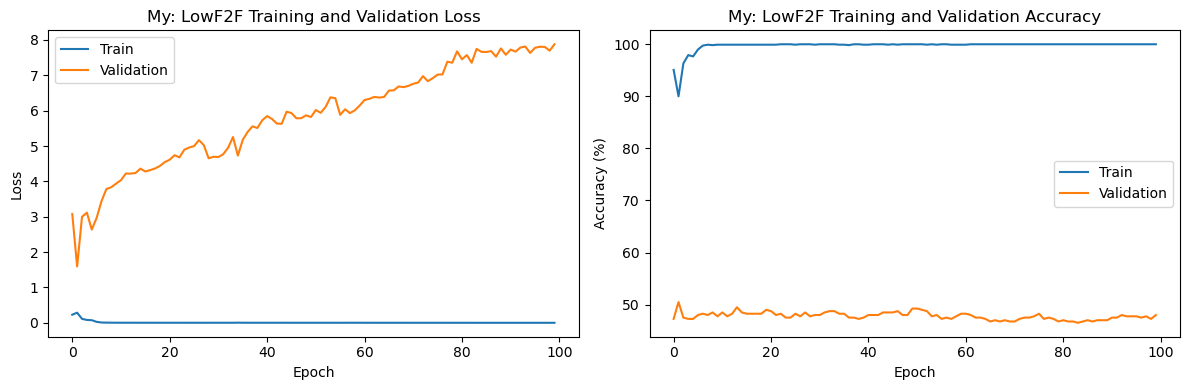

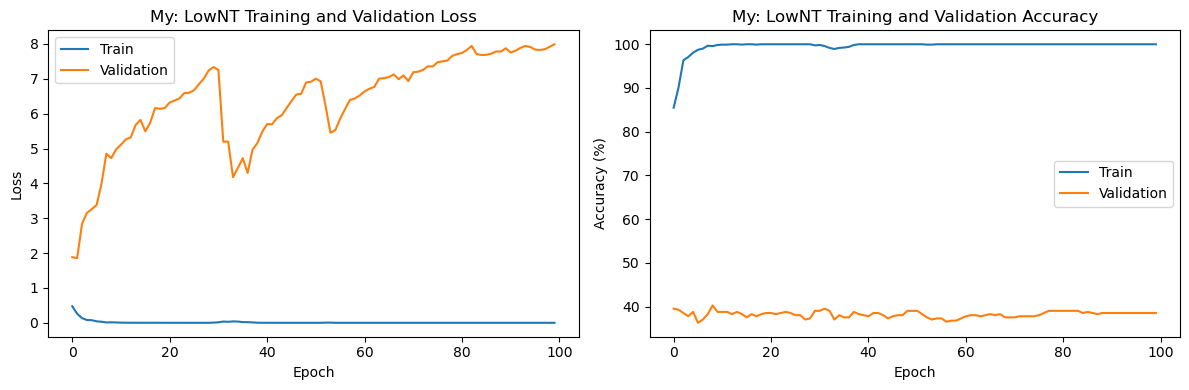

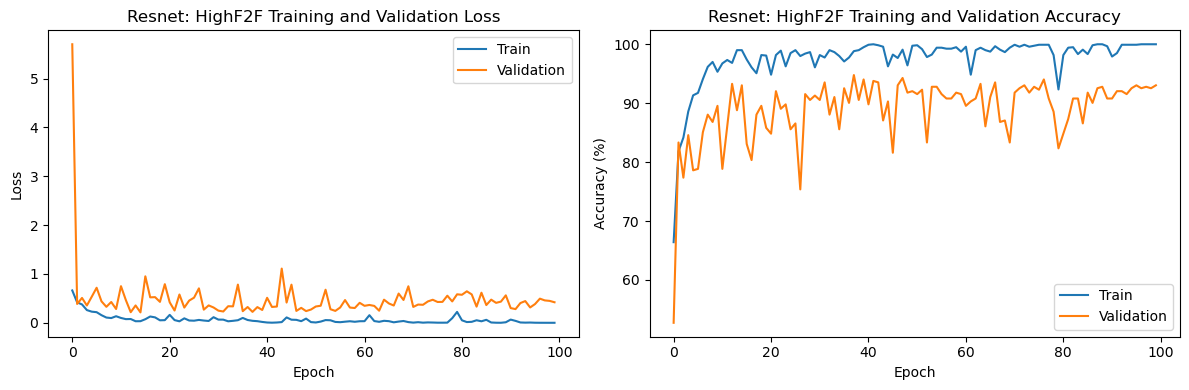

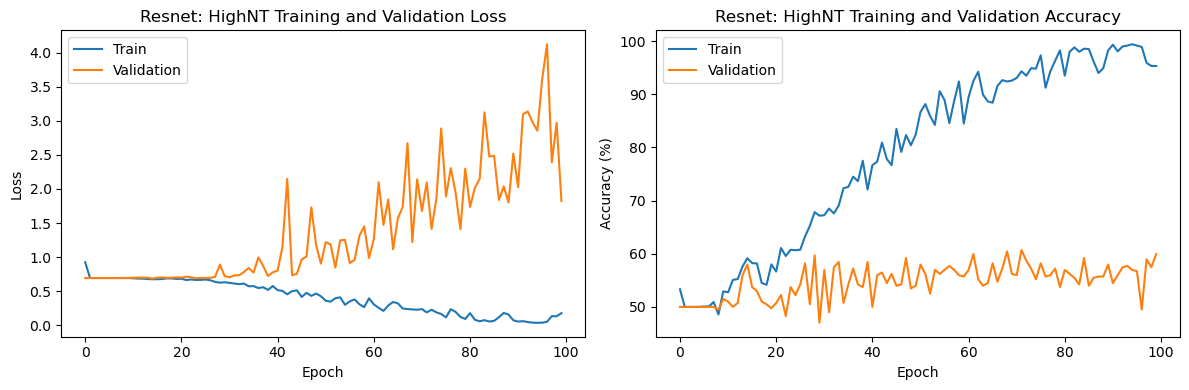

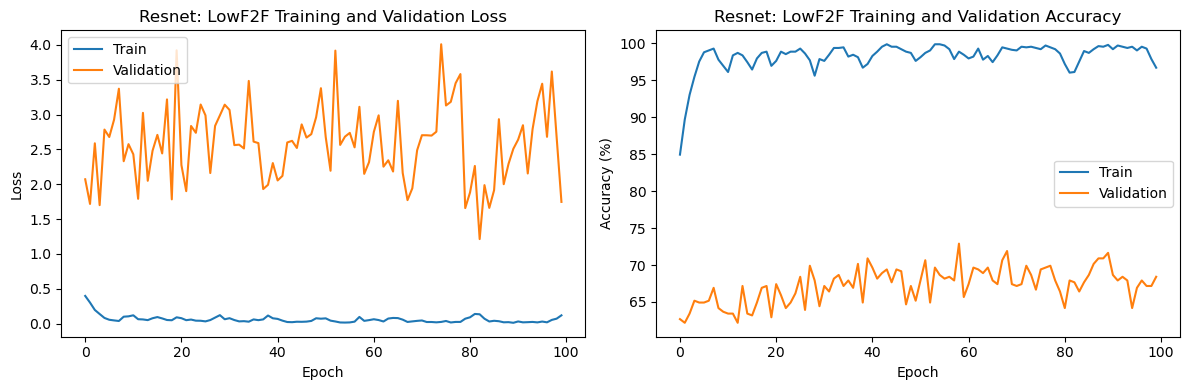

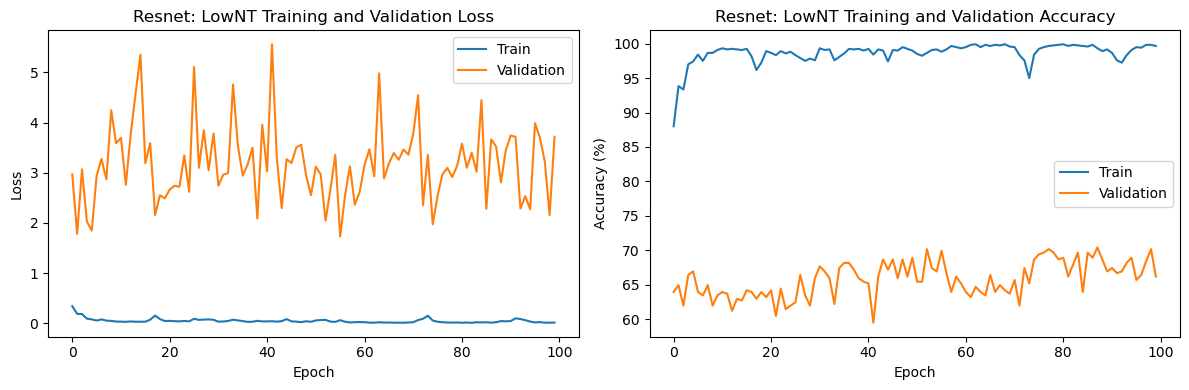

In [87]:
for result in train_results:
    name, category, train_losses, train_accs, valid_losses, valid_accs = result
    plot(train_losses, train_accs, valid_losses, valid_accs, name, category)

In [89]:
df_list = list()

for result in test_results:
    name, category, predictions, targets = result

    accuracy = accuracy_score(targets, predictions)
    f1 = f1_score(targets, predictions, average='weighted')
    precision = precision_score(targets, predictions, average='weighted')
    recall = recall_score(targets, predictions, average='weighted')
    df = pd.DataFrame({'Model': [name], 'Dataset': [category], 'Accuracy': [accuracy], 'F1 Score': [f1], 'Precision': [precision], 'Recall': [recall]})
    df_list.append(df)

report = pd.concat(df_list, ignore_index=True)
report.set_index(['Model', 'Dataset'], drop=True)

/opt/conda/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/opt/conda/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/opt/conda/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/opt/conda/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning

Accuracy  F1 Score  Precision    Recall
Model  Dataset                                         
My     HighF2F  0.533333  0.324354   0.355556  0.356892
       HighNT   0.533333  0.324354   0.355556  0.356892
       LowF2F   0.533333  0.324354   0.355556  0.356892
       LowNT    0.533333  0.324354   0.355556  0.356892
Resnet HighF2F  0.533333  0.324354   0.355556  0.356892
       HighNT   0.533333  0.324354   0.355556  0.356892
       LowF2F   0.533333  0.324354   0.355556  0.356892
       LowNT    0.533333  0.324354   0.355556  0.356892

## Test New Models (Video-DeepFake)

In [90]:
files = list(Path(new_model_path).iterdir())
files

[PosixPath('/kaggle/input/outputmodel/MyModel/My_HighF2F.pth'),
 PosixPath('/kaggle/input/outputmodel/MyModel/Resnet_LowF2F.pth'),
 PosixPath('/kaggle/input/outputmodel/MyModel/Resnet_LowNT.pth'),
 PosixPath('/kaggle/input/outputmodel/MyModel/My_LowNT.pth'),
 PosixPath('/kaggle/input/outputmodel/MyModel/Resnet_HighNT.pth'),
 PosixPath('/kaggle/input/outputmodel/MyModel/My_HighNT.pth'),
 PosixPath('/kaggle/input/outputmodel/MyModel/My_LowF2F.pth'),
 PosixPath('/kaggle/input/outputmodel/MyModel/Resnet_HighF2F.pth')]

In [91]:
model_dict = {}

for file_path in files:
    model_name = '_'.join(file_path.stem.split('_')[:-1])
    model, optimizer =  model_optimizers[model_name]
    checkpoint = torch.load(file_path)
    model.load_state_dict(checkpoint['model_state_dict'])

    model_dict[file_path] = [model, model_name]

In [136]:
test_results = []
for file_path, model_info in model_dict.items():
  model, name = model_info
  category = file_path.stem.split('_')[-1]
  predictions, targets = test(dl, model)
  result = (name, category, predictions, targets)
  test_results.append(result)

In [138]:
category_acc = {'H': [0 for _ in range(len(test_results[0][2]))], 'L': [0 for _ in range(len(test_results[0][2]))]}

for result in test_results:
  name, category, predictions, targets = result
  for i in range(len(predictions)):
    acc = 1 if targets[i] == predictions[i] else 0
    category_acc[category[0]][i] += acc

In [139]:
round(sum(HQ_acc)/len(HQ_acc), 2), round(sum(LQ_acc)/len(LQ_acc), 2)

(0.51, 0.51)

In [140]:
for result in test_results:
    name, category, predictions, targets = result
    accuracy = accuracy_score(targets, predictions)
    print(f'{name}_{category} Accuracy: {accuracy}')

My_HighF2F Accuracy: 0.5866666666666667
Resnet_LowF2F Accuracy: 0.5066666666666667
Resnet_LowNT Accuracy: 0.5066666666666667
My_LowNT Accuracy: 0.5866666666666667
Resnet_HighNT Accuracy: 0.5066666666666667
My_HighNT Accuracy: 0.5866666666666667
My_LowF2F Accuracy: 0.5866666666666667
Resnet_HighF2F Accuracy: 0.5066666666666667


#### Simple CNN is better

### Ensemble Simple CNN

In [141]:
cnn_models = []
for file_path, model_info in model_dict.items():
    model, name = model_info
    if name[0] == 'M':
        category = file_path.stem.split('_')[-1]
        cnn_models.append(model)
cnn_models

[MyModel(
   (conv1): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
   (conv2): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
   (conv3): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
   (maxpool): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
   (fc1): Linear(in_features=200704, out_features=512, bias=True)
   (fc2): Linear(in_features=512, out_features=2, bias=True)
   (relu): ReLU()
 ),
 MyModel(
   (conv1): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
   (conv2): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
   (conv3): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
   (maxpool): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
   (fc1): Linear(in_features=200704, out_features=512, bias=True)
   (fc2): Linear(in_features=512, out_features=2, bias=True)
   (relu): ReLU()
 ),
 MyModel(
   (conv1): Conv2d(3, 

In [172]:
class EnsembleModel(nn.Module):
    def __init__(self, num_classes, cnn_models):
        super(EnsembleModel, self).__init__()
        self.cnn_models = nn.ModuleList(cnn_models)
        self.fc = nn.Linear(4 * num_classes, num_classes)

    def forward(self, x):
        cnn_outputs = []
        for cnn_model in self.cnn_models:
            cnn_outputs.append(cnn_model(x))
        cnn_outputs = torch.cat(cnn_outputs, dim=1)
        outputs = self.fc(cnn_outputs)
        return outputs

In [173]:
num_classes = 2
ensemble_model = EnsembleModel(num_classes, cnn_models)
ensemble_model.to(device)
x = torch.randn(32, 3, 224, 224).to(device)
ensemble_model(x).shape

torch.Size([32, 2])

### Train CNN Ensemble Model

In [174]:
predictions, targets = test(dl, ensemble_model)
result = (name, category, predictions, targets)

In [175]:
ensemble_acc = []
name, category, predictions, targets = result
for i in range(len(predictions)):
  acc = 1 if targets[i] == predictions[i] else 0
  ensemble_acc.append(acc)

total_ensemble_acc = round(sum(ensemble_acc) / len(ensemble_acc), 2)
total_ensemble_acc

0.59

In [176]:
your_prediction['predict(New model)'] = ensemble_acc
your_prediction

,video,face,label,predict,predict(HQ model),predict(LQ model),predict(Ensemble model),predict(New model)
0,video_0,face_0.png,1,NaN,0.33,0.50,0,1
1,video_0,face_1.png,1,NaN,0.50,0.50,1,1
2,video_0,face_2.png,0,NaN,0.50,0.50,0,1
3,video_0,face_3.png,1,NaN,0.83,0.50,0,1
4,video_1,face_0.png,0,NaN,0.17,0.50,1,0
...,...,...,...,...,...,...,...,...
70,video_18,face_0.png,0,NaN,0.33,0.67,1,0
71,video_19,face_0.png,0,NaN,0.50,0.67,0,0
72,video_19,face_1.png,1,NaN,0.33,0.67,1,1
73,video_19,face_2.png,0,NaN,0.33,0.50,0,1


In [177]:
your_prediction.to_csv(Path(prediction_path) / 'your_prediction.csv', index=False)

In [179]:
torch.save(ensemble_model.state_dict(), Path(output_model_path) / 'Ensemble_CNN.pth')

## Result

Improve 0.52 to 0.57

# Train Ensemble Model (Xception and Efficient)

In [102]:
from torch.utils.data import ConcatDataset

train_ds_list = [dl[0].dataset for dl in dataloaders.values()]
valid_ds_list = [dl[1].dataset for dl in dataloaders.values()]
test_ds_list = [dl[2].dataset for dl in dataloaders.values()]

batch_size = 32  # Min-batches

combined_train_ds = ConcatDataset(train_ds_list)
combined_train_dl = DataLoader(combined_train_ds, batch_size=batch_size, shuffle=True)

combined_valid_ds = ConcatDataset(valid_ds_list)
combined_valid_dl = DataLoader(combined_valid_ds, batch_size=batch_size, shuffle=True)

combined_test_ds = ConcatDataset(test_ds_list)
combined_test_dl = DataLoader(combined_test_ds, batch_size=batch_size, shuffle=True)

In [103]:
optimizer6 = optim.Adam(ensemble_model.parameters(), lr=0.001)

In [119]:
save_path = os.path.join(new_model_path, 'Esemble_Efficient_Xception.pth')
if Path(save_path).exists():
    checkpoint = torch.load(save_path)
    ensemble_model.load_state_dict(checkpoint['model_state_dict'])
    train_losses = checkpoint['metrics']['train_losses']
    train_accs = checkpoint['metrics']['train_accs']
    valid_losses = checkpoint['metrics']['valid_losses']
    valid_accs = checkpoint['metrics']['valid_accs']
else:
    save_path = os.path.join(output_model_path, 'Esemble_Efficient_Xception.pth')
    best_state_dict, train_losses, train_accs, valid_losses, valid_accs = train(combined_train_dl, combined_valid_dl, ensemble_model, optimizer6, num_epochs=100, save=True, save_path=save_path)
    ensemble_model.load_state_dict(best_state_dict)
predictions, targets = test(combined_test_dl, ensemble_model)
train_result = ['Esemble_Efficient_Xception', 'All', train_losses, train_accs, valid_losses, valid_accs]
test_result = ['Esemble_Efficient_Xception', 'All', predictions, targets]

AttributeError: 'VotingClassifier' object has no attribute 'train'